# Ähnlichkeit von Dokumenten bestimmen

In [1]:
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import seaborn as sns
import numpy as np
import os,glob
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install sklearn

# Agenda
- TFIDF
- TFIDF für Sätze
- TFIDF für Dokumente
- Clustering mit TFIDF 
- Multidimensional Scaling mit TFIDF

- Oft möchte man in einem grossen Corpus herausfinden welche Dokumente irgendwie ähnlich sind, dh. ähnliche Themen haben oder einfach nur ähnliche Wörter benutzen. 
- Es gibt viele komplizierte Verfahren das zu tun. Das einfachste das ich kenne ist TF-IDF. 
- Wir nutzen: ```pip install sklearn```

# TF-IDF

Wiki Sagt: Das Tf-idf-Maß (von englisch term frequency ‚Vorkommenshäufigkeit‘ und inverse document frequency ‚inverse Dokumenthäufigkeit‘) wird im Information Retrieval zur Beurteilung der Relevanz von Termen in Dokumenten einer Dokumentenkollektion eingesetzt.

Ich sage salopp:
TF-IDF Ein Maß dafür wie relevant ein Wort für ein Dokument ist. 
- TF: Wie oft kommt das Wort vor? 
- DF: Wie oft kommt Wort im Dokument vor?
- Ein Quotient daraus gibt Wörtern die "charakeristisch" für ein Dokuement sind eine "höhere" Gewichtung. 

Es ist nicht wirklich wichtig zu wissen wie genau dieses Feature bestimmt wird, es ist aber sehr praktisch beim clustern von Dokumenten. Für diejenigen die es ganz genau wissen wollen ist hier ein super Einstieg dafür: https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

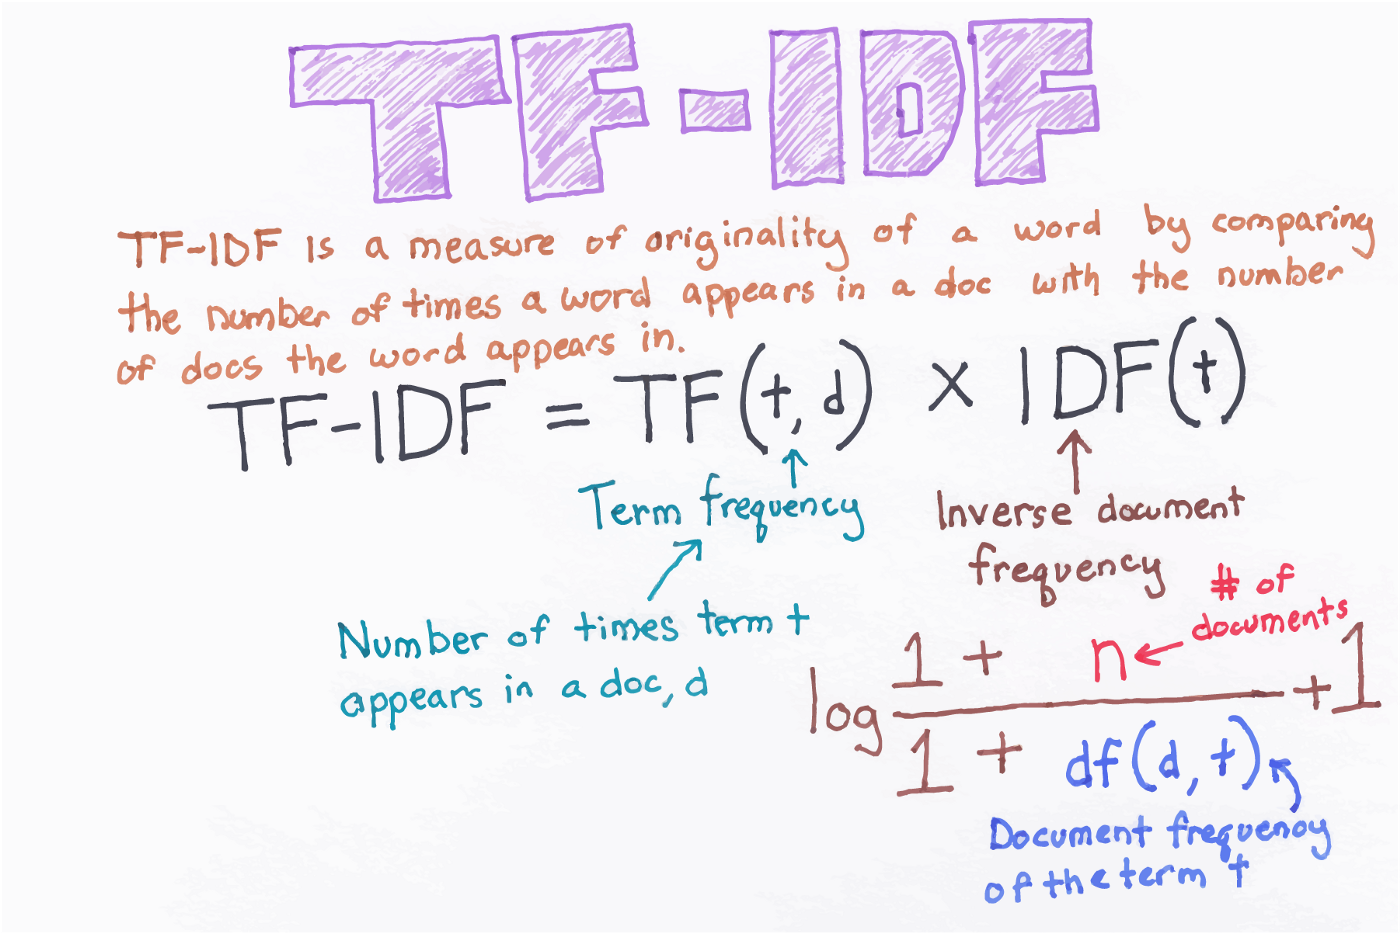

In [67]:
from IPython.display import Image
Image("tfidfcheat.png")

# TFIDF Beispiel

- Angenommen ein Dokument mit 100 Wörtern enthält das Wort "Katze" 3 mal
- Dann ist die Term Frequency (TF) 3/100 * 0.5+0.5 = 0.515
- Google hat, sagen wir mal 30 Trillionen Seiten und das Wort "Katze" kommt in 1.7 Billiarden Seiten vor
- Die Inverse Documente Frequency (IDF) ist log(30.000.000.000.000/1.700.000.000) = 6.5930
- Das TF-IDF (oder TF*IDF) Gewicht ist das Produkt von: 0.515*6.593 = 3.3954

## Beispiel für TF-IDF Werte von Wörtern

In [68]:
#!pip install sklearn

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

myvocabulary = ['life', 'learning', "cat", "the"]
corpus = {1: "The game of life is a game of everlasting learning", 2: "The unexamined life is not worth living", 3: "Never stop the learning", 4: "Life is great. Keep on the learning!", 5: "The cat crossed the street and died."}
tfidf = TfidfVectorizer(vocabulary = myvocabulary, ngram_range = (1,3))
tfs = tfidf.fit_transform(corpus.values())

feature_names = tfidf.get_feature_names()
corpus_index = [n for n in corpus]
df = pd.DataFrame(tfs.T.todense(), index=feature_names, columns=corpus_index)
tfs = tfidf.fit_transform(corpus.values())
df.T

,life,learning,cat,the
1,0.631667,0.631667,0.00000,0.449436
2,0.814802,0.000000,0.00000,0.579739
3,0.000000,0.814802,0.00000,0.579739
4,0.631667,0.631667,0.00000,0.449436
5,0.000000,0.000000,0.72391,0.689894


# TFIDF Beispiel für Sätze

- Mit diesem Code lässt sich für beliebige Sätze deren "Entfernung" berechnen. 
- Man schaut wie stark sich sätze bzgl. der TF-IDF Scores der Wörter die wir analysieren ähneln. 
- Diese kann man dann nutzen um zu sehen welche Sätze ähnlich sind. 

### Schritt 1: TFIDF für jeden Satz ausrechnen

In [5]:
vect = TfidfVectorizer(min_df=1)
corpus = ["I'd like an apple", "An apple a day keeps the doctor away", "Never compare an apple to an orange", "I prefer scikit-learn to Orange", "I went to the beach"]
tfidf = vect.fit_transform(corpus)
feature_names = vect.get_feature_names() 
df = pd.DataFrame(tfidf.todense()[0].T, index=feature_names, columns=["tfidf"]) 
df

,tfidf
an,0.486240
apple,0.486240
away,0.000000
beach,0.000000
compare,0.000000
day,0.000000
doctor,0.000000
keeps,0.000000
learn,0.000000
like,0.726044


###  Schritt 2 Distanz von jedem Satz mit jedem anderen Satz berechnen

In [6]:
tfidf.todense()[0]*tfidf.todense()[0].T

matrix([[1.]])

In [7]:
pd.DataFrame(tfidf.todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.486240,0.486240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.726044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.284329,0.284329,0.424555,0.000000,0.000000,0.424555,0.424555,0.424555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.342528,0.000000,0.000000
2,0.579517,0.289758,0.000000,0.000000,0.432661,0.000000,0.000000,0.000000,0.000000,0.000000,0.432661,0.349068,0.000000,0.000000,0.000000,0.289758,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493899,0.000000,0.000000,0.398475,0.493899,0.493899,0.000000,0.330770,0.000000
4,0.000000,0.000000,0.000000,0.568014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.458270,0.380406,0.568014


In [17]:
#(tfidf * tfidf.T).A

In [8]:
apples_matrix = (tfidf * tfidf.T).todense()
pd.DataFrame(apples_matrix)

,0,1,2,3,4
0,1.000000,0.276505,0.422677,0.000000,0.000000
1,0.276505,1.000000,0.247161,0.000000,0.156971
2,0.422677,0.247161,1.000000,0.234938,0.110226
3,0.000000,0.000000,0.234938,1.000000,0.125827
4,0.000000,0.156971,0.110226,0.125827,1.000000


## Visualisierung

In [9]:
!pip install seaborn

zsh:1: /Users/plotti/Library/Python/3.7/bin/pip: bad interpreter: /usr/local/opt/python/bin/python3.7: no such file or directory


In [10]:
#!pip install numpy

In [13]:
#mask = np.triu(np.ones_like(apples_matrix, dtype=np.bool))
#mask

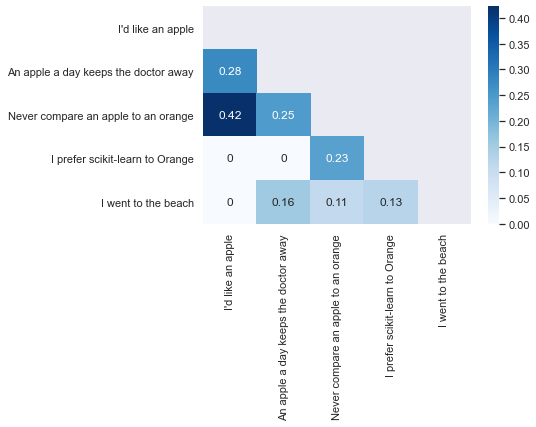

In [14]:
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()
mask = np.triu(np.ones_like(apples_matrix, dtype=np.bool))
labels = [w for w in corpus]
ax = sns.heatmap(apples_matrix,cmap="Blues",mask=mask,annot=True,xticklabels=labels,yticklabels=labels)

# TFIDF Beispiel für Dokumente mit Stemming und Stopword Entfernung

In [18]:
import nltk, string
from nltk.tokenize import word_tokenize
import os,glob

text_files = glob.glob(os.path.join("popsongs", '*.txt'))
#text_files = ["godfather.txt", "schindlers_list.txt", "shawnshank.txt"]
documents = [open(f).read() for f in text_files]

# Stemming
stemmer = nltk.stem.porter.PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

#Remove punctuaction, stem
def normalize(text):
    words = word_tokenize(text)
    words=[word.lower() for word in words if word.isalpha()]
    return stem_tokens(words)

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english').fit_transform(documents)

# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = vectorizer * vectorizer.T
pairwise_similarity = pairwise_similarity.A

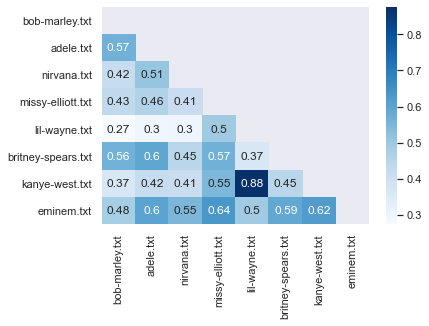

In [19]:
import seaborn as sns; sns.set()
labels = [w.split("/")[1] for w in text_files]
mask = np.triu(np.ones_like(pairwise_similarity, dtype=np.bool))
ax = sns.heatmap(pairwise_similarity,mask=mask,cmap="Blues",annot=True,xticklabels=labels,yticklabels=labels)

# Clustering mit TFIDF
- Clustering ist ein statistisches Verfahren um "ähnliche" dinge zusammen in ein "Cluster" zu legen. 
- Wichtig ist dass je nach verfahren die Anzahl der Cluster definiert werden muss. Hier 3. 
- Das Clustering Verfahren das hier verwendet wird heisst k-Means (https://de.wikipedia.org/wiki/K-Means-Algorithmus)

## Für Sätze

cluster  0 :
	sentence  0 :  Never compare an apple to an orange
	sentence  1 :  I prefer scikit-learn to Orange
cluster  1 :
	sentence  0 :  I'd like an apple
	sentence  1 :  An apple a day keeps the doctor away
cluster  2 :
	sentence  0 :  I went to the beach


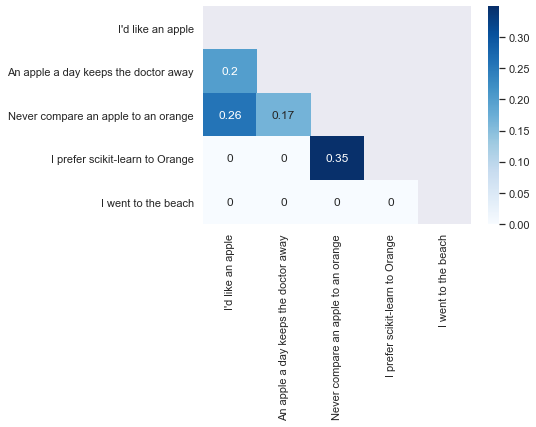

In [40]:
# Stemming
stemmer = nltk.stem.porter.PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

#Remove punctuaction, stem
def normalize(text):
    words = word_tokenize(text)
    words=[word.lower() for word in words if word.isalpha()]
    return stem_tokens(words)

def cluster_items2(items,categories,nb_of_clusters=5,mds=False):
    tfidf_matrix = TfidfVectorizer(tokenizer=normalize, stop_words='english').fit_transform(items)
    pairwise_similarity = tfidf_matrix * tfidf_matrix.T
    pairwise_similarity = pairwise_similarity.A
    labels = [w for w in categories]
    mask = np.triu(np.ones_like(pairwise_similarity, dtype=np.bool))
    ax = sns.heatmap(pairwise_similarity,cmap="Blues",mask=mask,annot=True,xticklabels=labels,yticklabels=labels)
    ax.plot()

    # Clustering
    kmeans = KMeans(n_clusters=nb_of_clusters,random_state=42)
    kmeans.fit(tfidf_matrix)
    clusters = collections.defaultdict(list)
    for i, label in enumerate(kmeans.labels_):
            clusters[label].append(i)
    if mds:
        return [pairwise_similarity,dict(clusters)]
    else:
        return dict(clusters)
        
items = ["I'd like an apple", "An apple a day keeps the doctor away", "Never compare an apple to an orange", "I prefer scikit-learn to Orange", "I went to the beach"]

nclusters= 3
clusters = cluster_items2(items,items,nclusters)
for cluster in range(nclusters):
        print("cluster ",cluster,":")
        for i,item in enumerate(clusters[cluster]):
                print("\tsentence ",i,": ",items[item])

## Für Textdokumente

In [41]:
text_files = glob.glob(os.path.join("popsongs", '*.txt'))
labels = [w.split("\/")[1].split(".")[0] for w in text_files]
items = [open(f).read() for f in text_files]

In [42]:
#text_files

In [43]:
#labels[0]

In [44]:
#items[0]

cluster  0 :
	document  0 :  popsongs/lil-wayne.txt
	document  1 :  popsongs/kanye-west.txt
cluster  1 :
	document  0 :  popsongs/adele.txt
	document  1 :  popsongs/nirvana.txt
	document  2 :  popsongs/cake.txt
	document  3 :  popsongs/missy-elliott.txt
	document  4 :  popsongs/eminem.txt
cluster  2 :
	document  0 :  popsongs/janisjoplin.txt
	document  1 :  popsongs/bob-marley.txt
	document  2 :  popsongs/britney-spears.txt


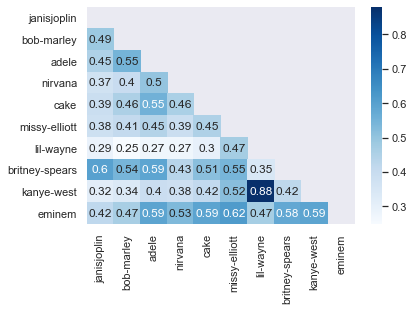

In [46]:
nclusters= 3
clusters = cluster_items2(items, labels, nclusters)
for cluster in range(nclusters):
        print("cluster ",cluster,":")
        for i,document in enumerate(clusters[cluster]):
                print("\tdocument ",i,": ",text_files[document])

# Multidimensional Scaling 
- Um ein Gefühl dafür zu bekommen wie die Daten geclustert als Punktewolke in 2D daliegen, kann man ein Verfahren nutzen dass sich Multidimensional Scaling nennt. Es versucht die Pairwise Distances so zu Layouten, dass Dokumente die nahe beieinander sind auch nebeneinander liegen.
- Doku hier: https://scikit-learn.org/stable/modules/manifold.html#multi-dimensional-scaling-mds

In [48]:
pairwise_distances

array([[1.        , 0.48917791, 0.45192229, 0.37256382, 0.3929009 ,
        0.3833173 , 0.29252351, 0.60069648, 0.31546687, 0.41937686],
       [0.48917791, 1.        , 0.54848525, 0.40050436, 0.4569697 ,
        0.40863309, 0.24823261, 0.54470175, 0.33781995, 0.46564106],
       [0.45192229, 0.54848525, 1.        , 0.49990227, 0.55488722,
        0.44516064, 0.27293017, 0.58933716, 0.39570203, 0.59335602],
       [0.37256382, 0.40050436, 0.49990227, 1.        , 0.45807487,
        0.39284961, 0.27421707, 0.43442136, 0.38494789, 0.53436264],
       [0.3929009 , 0.4569697 , 0.55488722, 0.45807487, 1.        ,
        0.45155078, 0.30058226, 0.51469741, 0.41560417, 0.59160966],
       [0.3833173 , 0.40863309, 0.44516064, 0.39284961, 0.45155078,
        1.        , 0.47166139, 0.54640036, 0.51774317, 0.61709549],
       [0.29252351, 0.24823261, 0.27293017, 0.27421707, 0.30058226,
        0.47166139, 1.        , 0.34802675, 0.87973007, 0.46782107],
       [0.60069648, 0.54470175, 0.5893371

cluster  0 :
	document  0 :  popsongs/lil-wayne.txt
	document  1 :  popsongs/kanye-west.txt
cluster  1 :
	document  0 :  popsongs/adele.txt
	document  1 :  popsongs/cake.txt
	document  2 :  popsongs/missy-elliott.txt
	document  3 :  popsongs/eminem.txt
cluster  2 :
	document  0 :  popsongs/janisjoplin.txt
	document  1 :  popsongs/bob-marley.txt
	document  2 :  popsongs/britney-spears.txt
cluster  3 :
	document  0 :  popsongs/nirvana.txt


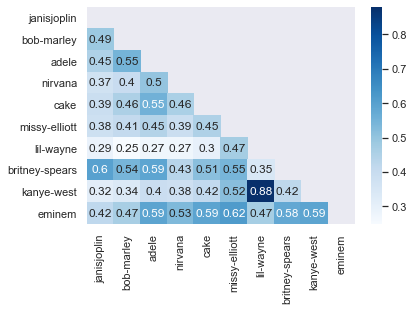

In [50]:
# Nochmal unser songtext beispiel
nclusters= 4
pairwise_distances, clusters = cluster_items2(items, labels, nclusters,True)
for cluster in range(nclusters):
        print("cluster ",cluster,":")
        for i,document in enumerate(clusters[cluster]):
                print("\tdocument ",i,": ",text_files[document])

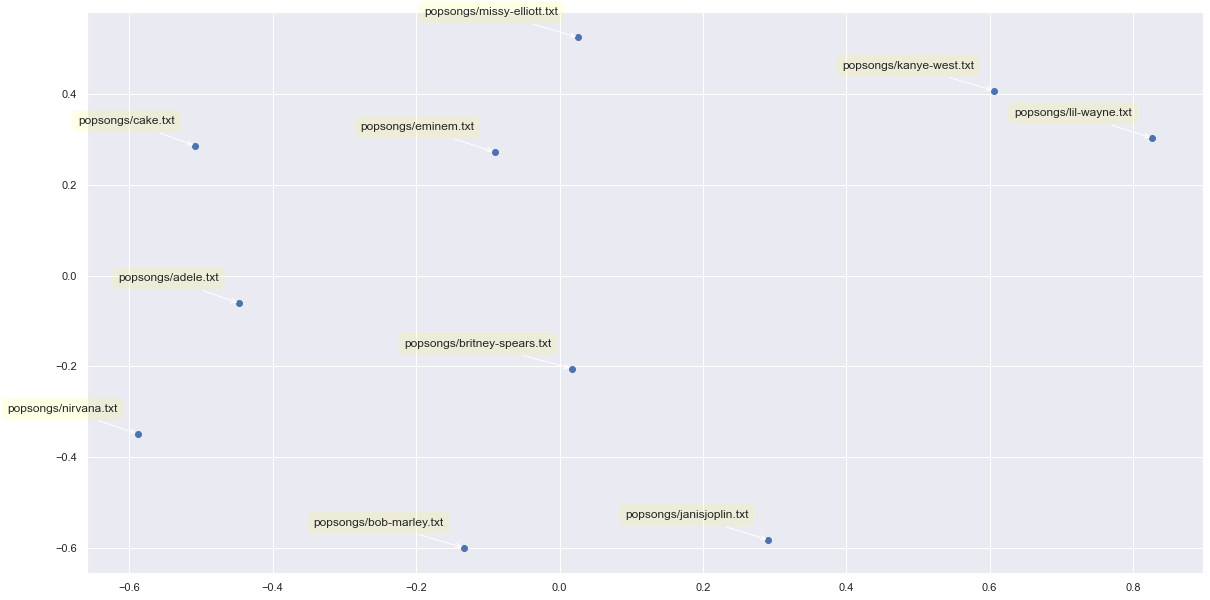

In [49]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

# siehe https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html
mds = manifold.MDS(n_components=2, random_state=6, metric=True)
results = mds.fit(pairwise_distances)

coords = results.embedding_

plt.figure(figsize=(20,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(text_files, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()


Ihr seht dass die Texte kleine "Cluster" bilden, dh. Punktewolken bei denen Texte näher beieinander liegen. 

# Final Remarks

Am Ende bleibt der "human touch" und ein wichtige offene Fragen:
 - Wieviele Cluster möchtet Ihr haben? Das bestimmt Ihr!
 - Wie gut lassen sich eigentlich die Dokumente separieren? (siehe Heatmap)
 - Wie sensitiv ist das Clustering, dh. wenn es mehrmals ausgeführt wird, oder sich die Daten leicht ändern, oder ihr mehr oder weniger Cluster macht - wie ändert sich auch das Resultat?